# Micrograd Advanced

More complete implementation of micrograd by better abstraction layer. Also compated to pytorch implementation.

In [4]:
import numpy as np
import pandas as pd
from graphviz import Digraph
import matplotlib.pyplot as plt

%matplotlib inline

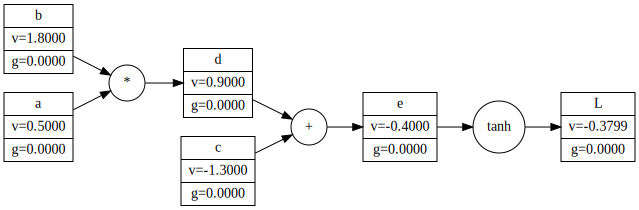

In [5]:
from abc import abstractmethod
from typing import List, Set, Tuple
from typing_extensions import Self

class Base:
    def __init__(self, name=None):
        self._name = name

    @property
    def id(self):
        return id(self)
    
    @property
    def name(self):
        if self._name is not None:
            return self._name
        return f"{self.__class__.__name__}({self.id})"

    @name.setter
    def name(self, value):
        self._name = value
    
    @abstractmethod
    def forward(self, pull: bool = True):
        '''Evaluates the forward pass'''
        raise NotImplementedError

    @abstractmethod
    def backward(self):
        '''Evaluates the backward pass'''
        raise NotImplementedError
    
    @abstractmethod
    def optimize(self, lr: float):
        '''Optimizes the parameters'''
        raise NotImplementedError

class Op(Base):
    '''Defines basic operator'''
    def __init__(self, inputs: List[Base], output: Base, name: str, op_name: str):
        super().__init__(name)
        self._values = inputs
        self._output = output
        self._op_name = op_name
    
    @property
    def op_name(self):
        return self._op_name

    @abstractmethod
    def _forward(self, pull: bool = False):
        raise NotImplementedError
    
    def forward(self, pull: bool = True):
        res = self._forward(pull=pull)
        self._output.data = res
        return res

    @abstractmethod
    def _backward(self):
        raise NotImplementedError
    
    def backward(self):
        for v in self._values:
            if v._grad is None:
                v._grad = 0

        # iterate the backward pass
        self._backward()

        # execute sub operations
        for v in self._values:
            v.backward()
    
    def optimize(self, lr: float):
        for v in self._values:
            v.optimize(lr)

class Add(Op):
    '''Defines addition operator'''
    def __init__(self, values: List[Base], output: Base, name: str):
        if len(values) != 2:
            raise ValueError(f"Add operator expects 2 values, got {len(values)}")
        super().__init__(values, output, name, "+")

    def _forward(self, pull: bool = True):
        return sum(v.forward(pull=pull) for v in self._values)

    def _backward(self):
        # distribute the gradient to the inputs
        for v in self._values:
            v._grad += self._output.grad

class Mul(Op):
    '''Defines multiplication operator'''
    def __init__(self, values: List[Base], output: Base, name: str):
        if len(values) != 2:
            raise ValueError(f"Mul operator expects 2 values, got {len(values)}")
        super().__init__(values, output, name, "*")

    def _forward(self, pull: bool = True):
        return np.prod([v.forward(pull=pull) for v in self._values])

    def _backward(self):
        # distribute the gradient to the inputs
        self._values[0]._grad += self._output.grad * self._values[1].forward(False)
        self._values[1]._grad += self._output.grad * self._values[0].forward(False)

class UniaryOp(Op):
    '''Defines basic uniary operator'''
    def __init__(self, values: List[Base], output: Base, name: str, op_name: str):
        if len(values) != 1:
            raise ValueError(f"Uniary operator expects 1 value, got {len(values)}")
        super().__init__(values, output, name, op_name)

class Tanh(UniaryOp):
    '''Defines tanh operator'''
    def __init__(self, values: List[Base], output: Base, name: str):
        super().__init__(values, output, name, "tanh")

    def _forward(self, pull: bool = True):
        return np.tanh(self._values[0].forward(pull=pull))

    def _backward(self):
        # distribute the gradient to the inputs
        self._values[0]._grad += self._output.grad * (1 - self._output.forward(False) ** 2)

def tanh(v: Base) -> Base:
    out = Value(0)
    op = Tanh([v], out, f"Tanh({v.name})")
    out._op = op
    out.data = op.forward(False)
    return out

class Value(Base):
    def __init__(self, data, name=None, freeze: bool = False, _op: Op=None):
        super().__init__(name)
        self.data = data
        self._grad = None
        self._op = _op
        self.optimized = False
        self._freeze = freeze
    
    @property
    def grad(self):
        if self._grad is not None:
            return self._grad
        # in case of origin data set the grad to 0
        return 0
    
    def __repr__(self):
        return f"Value({self.name}, data={self.data:.4f}, grad={self.grad:.4f})"
    
    def forward(self, pull: bool = True):
        # check if pulled
        if pull:
            self.optimized = False
            self._grad = None

            # check for operation to update the data
            if self._op is not None:
                self._op.forward(pull=pull)
        
        # return current data
        return self.data
    
    def backward(self):
        # in case this is first
        if self._grad is None:
            self._grad = 1

        # iterate the backward pass
        if self._op is not None:
            self._op.backward()

    def optimize(self, lr: float):
        if self.optimized:
            return
        if self._op is None:
            if self._freeze is False:
                self.data += lr * self.grad
                self.optimized = True
        else:
            self._op.optimize(lr)
    
    def _elevate(self, other):
        if isinstance(other, Value):
            return other
        return Value(other)
    
    def __add__(self, other):
        other = self._elevate(other)
        out = Value(0)
        op = Add([self, other], out, f"Add({self.name}, {other.name})")
        out._op = op
        out.data = op.forward(False)
        return out
    
    def __mul__(self, other):
        other = self._elevate(other)
        out = Value(0)
        op = Mul([self, other], out, f"Mul({self.name}, {other.name})")
        out._op = op
        out.data = op.forward(False)
        return out

def trace(value: Base) -> Tuple[Set[Base], Set[Tuple[Base, Base]]]:
    nodes, edges = set(), set()
    def _trace(value: Base):
        nodes.add(value)
        if isinstance(value, Value):
            if value._op is not None:
                edges.add((value._op, value))
                _trace(value._op)
        elif isinstance(value, Op):
            for v in value._values:
                edges.add((v, value))
                _trace(v)
            
    _trace(value)
    return nodes, edges

def plot(v: Base) -> Digraph:
    '''Plots the graph'''
    # generate base data
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(v)

    for node in nodes:
        if isinstance(node, Value):
            dot.node(str(node.id), label=f"{node.name or ''} | v={node.data:.4f} | g={node.grad:.4f}", shape='record')
        elif isinstance(node, Op):
            dot.node(str(node.id), label=node.op_name, shape='circle')

    # add edges
    for src, dst in edges:
        dot.edge(str(src.id), f"{str(dst.id)}")

    return dot

a = Value(0.5, name="a")
b = Value(1.8, name="b")
c = Value(-1.3, name="c")
d = a * b; d.name = "d"
e = d + c; e.name = "e"
L = tanh(e); L.name = "L"

plot(L)

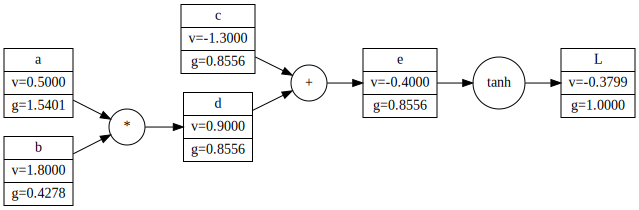

In [53]:
# study backward pass
L.backward()
plot(L)

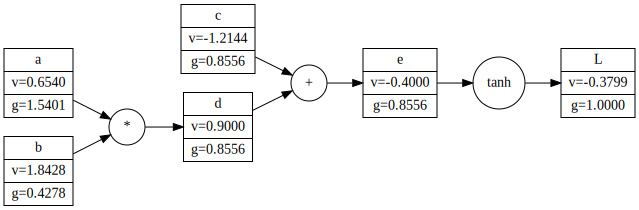

In [54]:
L.optimize(0.1)
plot(L)

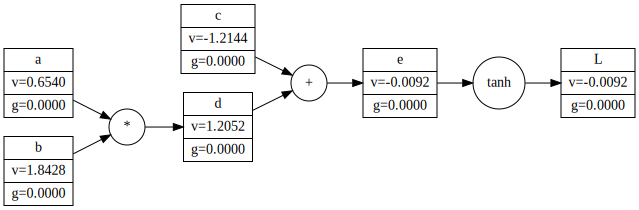

In [55]:
L.forward()
plot(L)

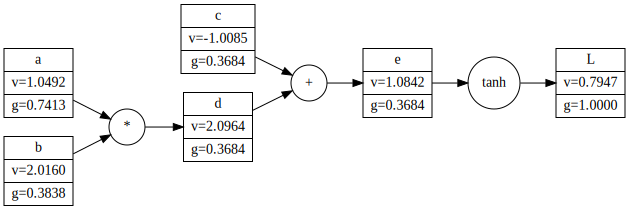

In [85]:
L.forward()
L.backward()
L.optimize(0.01)
plot(L)

Testing edge cases

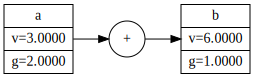

In [87]:
a = Value(3, name="a")
b = a + a; b.name = "b"
b.backward()
plot(b)

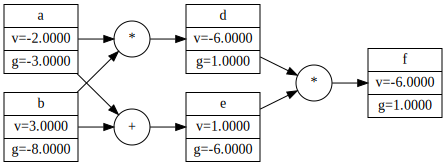

In [88]:
a = Value(-2, name="a")
b = Value(3, name="b")
d = a * b; d.name = "d"
e = a + b; e.name = "e"
f = d * e; f.name = "f"
f.backward()
plot(f)

Single Layer Perceptron

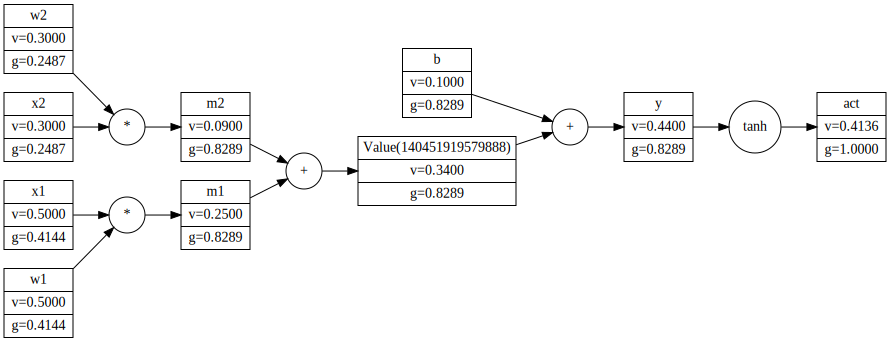

In [9]:
w1 = Value(0.5, name="w1")
w2 = Value(0.3, name="w2")
b = Value(0.1, name="b")
x1 = Value(0.5, name="x1", freeze=True)
x2 = Value(0.3, name="x2", freeze=True)
m1 = w1 * x1; m1.name = "m1"
m2 = w2 * x2; m2.name = "m2"
y = m1 + m2 + b; y.name = "y"
act = tanh(y); act.name = "act"
act.backward()
plot(act)

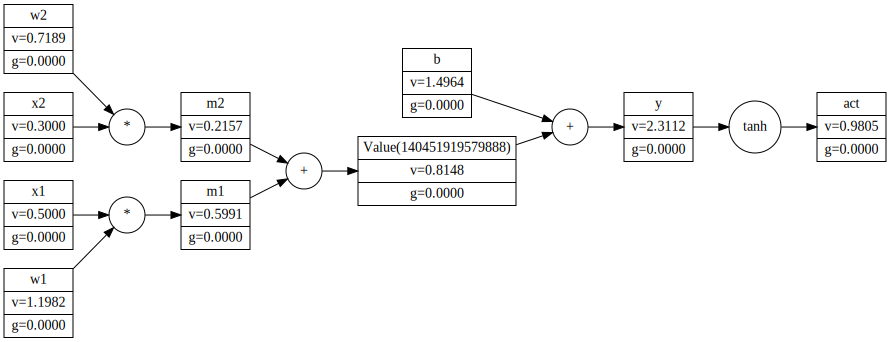

In [10]:
for i in range(10000):
    act.forward()
    act.backward()
    act.optimize(0.001)

act.forward()
plot(act)

## Building Network in Pytorch

In [2]:
import torch
torch.__version__

'1.13.0.dev20220803'

Out: -0.3799 to -0.3799
a: 1.5401 to 1.5401
b: 0.4278 to 0.4278
c: 0.8556 to 0.8556


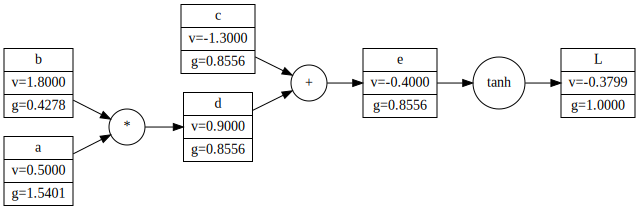

In [15]:
# create basic Tensor values
ta = torch.tensor(0.5, requires_grad=True)
tb = torch.tensor(1.8, requires_grad=True)
tc = torch.tensor(-1.3, requires_grad=True)
td = ta * tb
te = td + tc
tL = torch.tanh(te)
tL.backward()


# ours
a = Value(0.5, name="a")
b = Value(1.8, name="b")
c = Value(-1.3, name="c")
d = a * b; d.name = "d"
e = d + c; e.name = "e"
L = tanh(e); L.name = "L"
L.backward()

print(f"Out: {L.data:.4f} to {tL.data:.4f}")
print(f"a: {a.grad:.4f} to {ta.grad:.4f}")
print(f"b: {b.grad:.4f} to {tb.grad:.4f}")
print(f"c: {c.grad:.4f} to {tc.grad:.4f}")

# plot as well
plot(L)

Seems like frameworks agree :)

## Create Neuron in our Framework

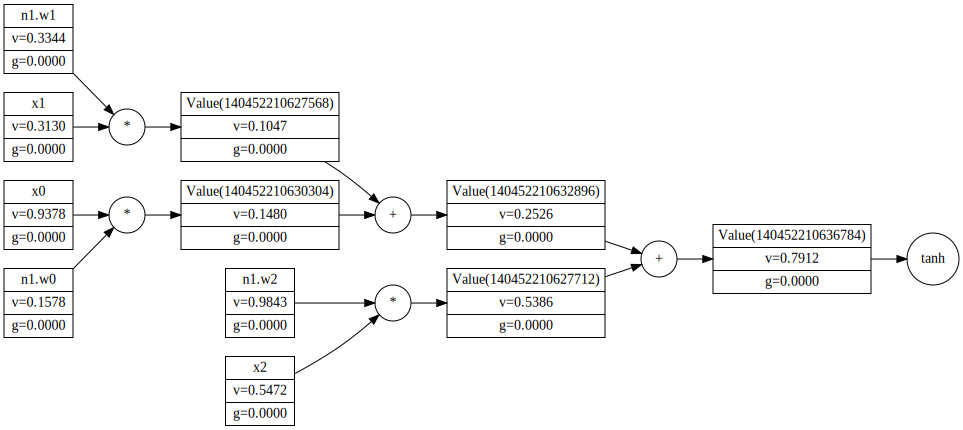

In [21]:
from random import random
from typing import Type

class Neuron(Base):
    def __init__(self, inputs: List[Value], act: Type[UniaryOp], name: str = None):
        super().__init__(name=name)
        self._inputs = inputs
        self._op = act
        self._weights = [Value(random(), name=f"{name}.w{i}") for i in range(len(inputs))]
        self._bias = Value(random(), name=f"{name}.b")
        self._sum = None
        for i, x in enumerate(self._inputs):
            if self._sum is None:
                self._sum = self._weights[i] * x
            else:
                self._sum = self._sum + (self._weights[i] * x)
        self._out = Value(0, name=f"{name}.act_out")
        self._op = act([self._sum], self._out, name=f"{name}.act")
        self._out.data = self._op.forward(False)
    
    def forward(self, pull: bool = True):
        return self._out.forward(pull)
    
    def backward(self):
        self._out.backward()
    
    def optimize(self, lr: float):
        self._out.optimize(lr)
    

x = [Value(random(), name=f"x{i}") for i in range(3)]
n = Neuron(x, Tanh, name="n1")
n.forward()

def trace(value: Base, trace_n: bool = False) -> Tuple[Set[Base], Set[Tuple[Base, Base]]]:
    nodes, edges = set(), set()
    def _trace(value: Base):
        if not isinstance(value, Neuron) or trace_n:
            nodes.add(value)
        if isinstance(value, Value):
            if value._op is not None:
                edges.add((value._op, value))
                _trace(value._op)
        elif isinstance(value, Op):
            for v in value._values:
                edges.add((v, value))
                _trace(v)
        elif isinstance(value, Neuron):
            if trace_n:
                for v in value._inputs:
                    edges.add((v, value))
                    _trace(v)
            else:
                edges.add((value._op, value))
                _trace(value._op)
            
    _trace(value)
    return nodes, edges

def plot(v: Base, plot_n: bool = False) -> Digraph:
    '''Plots the graph'''
    # generate base data
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(v, plot_n)

    for node in nodes:
        if isinstance(node, Value):
            dot.node(str(node.id), label=f"{node.name or ''} | v={node.data:.4f} | g={node.grad:.4f}", shape='record')
        elif isinstance(node, Op):
            dot.node(str(node.id), label=node.op_name, shape='circle')
        elif isinstance(node, Neuron) and plot_n:
            dot.node(str(node.id), label=node.name, shape='square')

    # add edges
    for src, dst in edges:
        if (isinstance(src, Neuron) or isinstance(dst, Neuron)) and not plot_n:
            continue
        dot.edge(str(src.id), f"{str(dst.id)}")

    return dot

plot(n, False)

Now build a layer of neurons and a loss function - then optimize it. For that we would also need to build a range of data.

In [ ]:
# TODO: